In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('mode.chained_assignment', None)
plt.style.use('ggplot')

# loading raw csv data 
df_data = pd.read_csv('./1976-2016-president.csv', error_bad_lines=False)

election_pc_coefficient=0
election_pc_intercept=0
tp_pc_coefficient=0
tp_pc_intercept=0

election_percentvote = []
reelection_percentvote = []
candidate_array = []
trump_incumbent = []

percentchange_vote = []

third_party = []
trump_third_party = []

reelection_tp_votes = []

trump_actual = 46.8
biden_actual = 51.3

presidents_tuple = ("Carter, Jimmy","Reagan, Ronald","Bush, George H.W.",
              "Clinton, Bill","Bush, George W.","Obama, Barack H.","Trump, Donald J.")

def clean_data():
    # Delete rows without past Presidents in them
    updated_df = []
    for i, row in df_data.iterrows():
        candidate = row[7]
        # if the candidate is a past president (including Trump)
        if(candidate==presidents_tuple[0] or candidate==presidents_tuple[1] or candidate==presidents_tuple[2] or candidate==presidents_tuple[3] or candidate==presidents_tuple[4] or candidate==presidents_tuple[5] or candidate==presidents_tuple[6]):
            updated_df.append(row)
    # Sort into first general election percent votes and second re-election percent votes
    for row in updated_df:
        date = row[0]
        candidate = row[7]
        party = row[8]
        percentvote = row[12]
        # First general election percent votes sort
        if(date==1976 and presidents_tuple[0]==candidate)or(date==1980 and presidents_tuple[1]==candidate)or(date==1988 and presidents_tuple[2]==candidate)or(date==1992 and presidents_tuple[3]==candidate)or(date==2000 and presidents_tuple[4]==candidate)or(date==2008 and presidents_tuple[5]==candidate):
            election_percentvote.append(percentvote)
            candidate_array.append(candidate)
            if(percentvote<.18):
                print(candidate)
                print(percentvote)
        # Second general election percent votes sort
        elif(date==1980 and presidents_tuple[0]==candidate)or(date==1984 and presidents_tuple[1]==candidate)or(date==1992 and presidents_tuple[2]==candidate)or(date==1996 and presidents_tuple[3]==candidate)or(date==2004 and presidents_tuple[4]==candidate)or(date==2012 and presidents_tuple[5]==candidate):
            reelection_percentvote.append(percentvote)
        elif(date==2016 and presidents_tuple[6]==candidate):
            trump_incumbent.append(percentvote)
    # Debugging purposes: len(election_percentvote)==len(reelection_percentvote) and len(trump_incumbent)==50
    # print(len(election_percentvote))
    # print(len(reelection_percentvote))
    # print(len(trump_incumbent))

def clean_data2():
    current_date = 1976
    current_state = "AL"
    third_party_sum = 0
    trump_tp_sum = 0
    for i, row in df_data.iterrows():
        year = row[0]
        state = row[2]
        party = row[8]
        percentchange = row[12]
        # If the year is an election year for a past president's first term (not including trump)
        if (year == 1976 or year == 1980 or year == 1988 or year == 1992 or year == 2000 or year == 2008):
            # the pointed year / state is different from the current year / state
            if(year != current_date or state != current_state):
                # Debug
                # print(str(year) + state)
                # print("Third Party Sum! " + str(third_party_sum))
                third_party.append(third_party_sum)
                third_party_sum = 0
                current_date = year
                current_state = state
            # the pointed year / state is the same as the current year / state
            else:
                if (party != "democrat" and party != "republican"):
                    #print(percentchange)
                    third_party_sum += percentchange
        # it's 2016 
        elif(year == 2016):
            # the pointed year / state is different from the current year / state
            if(year != current_date or state != current_state):
                # Debug
                # print(str(year) + state)
                # print("Trump's Third Party Sum! " + str(trump_tp_sum))
                trump_third_party.append(trump_tp_sum)
                trump_tp_sum = 0
                current_date = year
                current_state = state
            # the pointed year / state is the same as the current year / state
            else:
                if (party != "democrat" and party != "republican"):
                    trump_tp_sum += percentchange
    third_party.append(.041695) # WY 2012 isn't accounted for

def clean_data3():
    current_date=1976
    current_state="AL"
    third_party_sum=0
    
    for i, row in df_data.iterrows():
        year = row[0]
        state = row[2]
        candidate = row[7]
        party = row[8]
        percentchange = row[12]
        # Relection Turnout Amongst Third Party
        if(year==1980 or year==1984 or year==1988 or year==1996 or year==2004 or year==2012):
            if(year!=current_date or state!=current_state):
                #print(str(year) + state)
                #print("SUM! "+str(third_party_sum))
                reelection_tp_votes.append(third_party_sum)
                third_party_sum=0
                current_date=year
                current_state=state
            else:
                if(party!="democrat" and party!="republican"):
                    #print(percentchange)
                    third_party_sum+=percentchange
                    
# Uses linear least squares to determine a line of best fit in the form y=mx+b
# Returns [slope,y-intercept] in the form [a_1,a_0]
def linear_regression(x_col,y_col):
    # Method of Least Squares formula from lecture notes "SP 22 Approximation Theory"
    m=len(x_col)
    x_squared_sum = np.multiply(x_col,x_col).sum();
    x_single_sum = sum(x_col);
    y_single_sum = sum(y_col);
    x_y_sum = np.multiply(x_col,y_col).sum();
    denom = m*x_squared_sum-pow(x_single_sum,2);
    a_0 = (x_squared_sum*y_single_sum-x_y_sum*x_single_sum)/denom;
    a_1 = (m*x_y_sum-x_single_sum*y_single_sum)/denom;
    return [a_1,a_0]

# Creates a plot given: the line of best fit, x_col, y_col, x-axis limits, y-axis limits, x-axis title, y-axis title
# The title is the line of best fit equation
# This plot takes into account party affiliation
def plot_figure(eqn,x_array,y_array,xylimit,xyaxes):
    # Sorts president by their party affiliations: rep for republican, dem for democrat
    rep_x_array = []
    rep_y_array = []
    dem_x_array = []
    dem_y_array = []
    for i in range(len(candidate_array)):
        if(candidate_array[i]=="Carter, Jimmy" or candidate_array[i]=="Clinton, Bill" or candidate_array[i]=="Obama, Barack H."):
            dem_x_array.append(x_array[i])
            dem_y_array.append(y_array[i])
        elif(candidate_array[i]=="Reagan, Ronald" or candidate_array[i]=="Bush, George H.W." or candidate_array[i]=="Bush, George W."):
            rep_x_array.append(x_array[i])
            rep_y_array.append(y_array[i])
        # for debugging purposes / if a third-party candidate wins president in the future
        else:
            print(candidate_array[i])
    
    # Set titles and axes
    plt.figure(figsize=(10, 6))
    plt.title(f"Y = {round(eqn[0],10)} X + {round(eqn[1],10)}")
    plt.xlim(xylimit[0], xylimit[1])
    plt.ylim(xylimit[2], xylimit[3])
    plt.xlabel(xyaxes[0])
    plt.ylabel(xyaxes[1])
    
    # Scatterplot
    plt.scatter(rep_x_array,rep_y_array,color='red')
    plt.scatter(dem_x_array,dem_y_array,color='blue')
    
    # Line plot
    x = np.linspace(0, 10, 1000)
    y = eqn[0]*x+eqn[1]
    plt.plot(x,y, '--g')

# Creates a plot given: the line of best fit, x_col, y_col, x-axis limits, y-axis limits, x-axis title, y-axis title
# The title is the line of best fit equation
# This plot does not take into account party affiliation
def plot_figure_without_blocs(eqn,x_array,y_array,xylimit,xyaxes):
    plt.figure(figsize=(10, 6))
    plt.title(f"Y = {round(eqn[0],10)} X + {round(eqn[1],10)}")
    plt.xlim(xylimit[0], xylimit[1])
    plt.ylim(xylimit[2], xylimit[3])
    plt.ylabel(xyaxes[1])
    plt.xlabel(xyaxes[0])
    # Scatterplot
    plt.scatter(x_array,y_array,color='dodgerblue')
    # Line plot
    x = np.linspace(0, 10, 1000)
    y = eqn[0]*x+eqn[1]
    plt.plot(x,y, '--g')

def plot_election_reelection():
    clean_data()
    # Relationship between First Election Results and Re-Election Results
    # returns line of best fit: [slope,y-intercept]
    election_reelection_regression=linear_regression(election_percentvote,reelection_percentvote)
    # Plots election performance vs reelection performance with line of best fit
    # x-axis: [0.2,0.8], "First Election Percent of Vote"
    # y-axis [0.1,0.9], "Re-Election Percent of Vote"
    plot_figure(election_reelection_regression,election_percentvote,reelection_percentvote,[0.2,0.8,0.1,0.9],["First Election Percent of Vote","Re-Election Percent of Vote"])

def plot_election_percentchange():
    # Relationship between First Election Results and Percent Change
    # returns line of best fit: [slope,y-intercept]
    percentchange_vote = np.subtract(reelection_percentvote,election_percentvote)
    election_percentchange_regression=linear_regression(election_percentvote,percentchange_vote)
    # Plots election performance vs percent change of vote in reelection with line of best fit
    # x-axis: [0.2,0.8], "First Election Percent of Vote"
    # y-axis [-0.3,0.3], "Percent Change of Vote in Re-election"
    plot_figure(election_percentchange_regression,election_percentvote,percentchange_vote,[0.2,0.8,-0.3,0.3],["First Election Percent of Vote","Percent Change of Vote in Re-election"])
    return election_percentchange_regression
    
def plot_thirdpartyinfluence_percentchange():
    clean_data2()
    percentchange_vote = np.subtract(reelection_percentvote,election_percentvote)
    # Relationship between Third - Party Percent of Votes and Percent Change
    # returns line of best fit : [slope, y - intercept]
    thirdpartyinfluence_regression = linear_regression(third_party, percentchange_vote)
    # Plots election performance vs percent change of vote in reelection with line of best fit
    # x - axis: [0.2, 0.8] , "First Election Percent of Vote"
    # y - axis[-0.3, 0.3], "Percent Change of Vote in Re-election"
    plot_figure_without_blocs(thirdpartyinfluence_regression, third_party, percentchange_vote, [0, .3, -.3, .3], ["Third Party Percent of Vote in Election", "Percent Change of Vote in Re-Election"])
    return thirdpartyinfluence_regression
    
def findPercentChangeinTrumpVote(reelection_pc, tp_influence):
    trump_election_average = np.mean(trump_incumbent)
    trump_tp_average = np.mean(trump_third_party)
    # tp_influence[0]=0   # THIS WOULD BE COMMENTED OUT IF WE TAKE THIRD PARTY INTO CONSIDERATION
    # tp_influence[1]=0   # THIS WOULD BE COMMENTED OUT IF WE TAKE THIRD PARTY INTO CONSIDERATION
    trump_percentchange=reelection_pc[0]*trump_election_average+tp_influence[0]*trump_tp_average+reelection_pc[1]+tp_influence[1]
    djt_projected = 100*(trump_election_average+trump_percentchange)
    print("Donald Trump: "+ str(djt_projected)+"%")
    
    clean_data3()
    tp_e_re_regression=linear_regression(election_percentvote,reelection_tp_votes)
    plot_figure_without_blocs(tp_e_re_regression,election_percentvote,reelection_tp_votes,[.3,.7,0,.25],["First Election Percent of Vote","Re-Election Third Party Percent of Vote"])
    third_party_projected = tp_e_re_regression[0]*trump_election_average+tp_e_re_regression[1]
    jb_projected=100-(djt_projected)-100*(third_party_projected)
    print("Joe Biden: "+ str(jb_projected)+"%")
    djt_abs_error = abs(47.1-djt_projected)
    djt_rel_error = djt_abs_error/47.1
    print("DJT Absolute Error: " + str(djt_abs_error))
    print("DJT Relative Error: " + str(djt_rel_error))
    jb_abs_error = abs(51.1-jb_projected)
    jb_rel_error = jb_abs_error/51.1
    print("JB Absolute Error: " + str(jb_abs_error))
    print("JB Relative Error: " + str(jb_rel_error))

def main():
    plot_election_reelection()
    election_percentchange_regression = plot_election_percentchange()
    thirdpartyinfluence_regression = plot_thirdpartyinfluence_percentchange()
    findPercentChangeinTrumpVote(election_percentchange_regression,thirdpartyinfluence_regression)
main()

b'Skipping line 3: expected 1 fields, saw 2\nSkipping line 4: expected 1 fields, saw 5\nSkipping line 5: expected 1 fields, saw 2\nSkipping line 7: expected 1 fields, saw 2\nSkipping line 9: expected 1 fields, saw 2\nSkipping line 14: expected 1 fields, saw 2\nSkipping line 19: expected 1 fields, saw 2\nSkipping line 21: expected 1 fields, saw 2\nSkipping line 23: expected 1 fields, saw 3\nSkipping line 26: expected 1 fields, saw 2\nSkipping line 27: expected 1 fields, saw 4\nSkipping line 28: expected 1 fields, saw 4\nSkipping line 32: expected 1 fields, saw 3\nSkipping line 38: expected 1 fields, saw 4\nSkipping line 39: expected 1 fields, saw 3\nSkipping line 41: expected 1 fields, saw 2\nSkipping line 44: expected 1 fields, saw 2\nSkipping line 49: expected 1 fields, saw 2\nSkipping line 55: expected 1 fields, saw 2\nSkipping line 56: expected 1 fields, saw 3\nSkipping line 61: expected 1 fields, saw 3\nSkipping line 62: expected 1 fields, saw 4\nSkipping line 65: expected 1 fields

IndexError: index 7 is out of bounds for axis 0 with size 1

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('mode.chained_assignment', None)
plt.style.use('ggplot')

# loading raw csv data 
df_data = pd.read_csv('./1978-2018-senate.csv', error_bad_lines=False,encoding= 'unicode_escape')
df2_data = pd.read_csv('./senate2020.csv', error_bad_lines=False)


election_pc_coefficient=0
election_pc_intercept=0
tp_pc_coefficient=0
tp_pc_intercept=0

election_percentvote = []
reelection_percentvote = []
candidate_array = []
trump_incumbent = []

percentchange_vote = []

third_party = []
trump_third_party = []

reelection_tp_votes = []

senator_tuple = ("Sam Nunn","Mack Mattingly","Wyche Fowler Jr.",
              "Paul Coverdell","Max Cleland","Saxby Chambliss","Johnny Isakson")

def clean_data():
    # Sort into first general election percent votes and second re-election percent votes
    for i, row in df_data.iterrows():
        date = row[0]
        candidate = row[8]
        party = row[9]
        percentvote = row[12]
        state = row[2]
        if state=="GA":
            # First general election percent votes sort
            if((date==1978 and senator_tuple[0]==candidate)or
            (date==1980 and senator_tuple[1]==candidate)or
            (date==1986 and senator_tuple[2]==candidate)or
            (date==1992 and senator_tuple[3]==candidate)or
            (date==1996 and senator_tuple[4]==candidate)or
            (date==2002 and senator_tuple[5]==candidate)or
            (date==2004 and senator_tuple[6]==candidate)or 
            (date==2010 and senator_tuple[6]==candidate)):
                election_percentvote.append(percentvote)
                candidate_array.append(candidate)
            # Second general election percent votes sort
            if((date==1984 and senator_tuple[0]==candidate)or
            (date==1986 and senator_tuple[1]==candidate)or
            (date==1992 and senator_tuple[2]==candidate)or
            (date==1998 and senator_tuple[3]==candidate)or
            (date==2002 and senator_tuple[4]==candidate)or
            (date==2008 and senator_tuple[5]==candidate)or
            (date==2010 and senator_tuple[6]==candidate)or
            (date==2016 and senator_tuple[6]==candidate)):
                reelection_percentvote.append(percentvote)

def clean_data2():
    current_date = 1978
    current_state = "GA"
    third_party_sum = 0
    for i, row in df_data.iterrows():
        year = row[0]
        state = row[2]
        party = row[9]
        percentchange = row[12]
        if state=="GA":
            # If the year is an election year for a past president's first term (not including trump)
            if (year == 1978 or year == 1980 or year == 1986 or year == 1992 or year == 1996 or year == 2002 or year==2004 or year==2010 or year==2014):
                # the pointed year / state is different from the current year / state
                if(year != current_date or state != current_state):
                    # Debug
                    # print(str(year) + state)
                    # print("Third Party Sum! " + str(third_party_sum))
                    third_party.append(third_party_sum)
                    third_party_sum = 0
                    current_date = year
                    current_state = state
                # the pointed year / state is the same as the current year / state
                else:
                    if (party != "democrat" and party != "republican"):
                        #print(percentchange)
                        third_party_sum += percentchange

def clean_data3():
    current_date=1978
    current_state="GA"
    third_party_sum=0
    
    for i, row in df_data.iterrows():
        year = row[0]
        state = row[2]
        party = row[9]
        percentchange = row[12]
        # Relection Turnout Amongst Third Party
        if state=="GA":
            if(year==1984 or year==1986 or year==1992 or year==1998 or year==2002 or year==2008 or year==2010 or year==2016):
                if(year!=current_date or state!=current_state):
                    reelection_tp_votes.append(third_party_sum)
                    third_party_sum=0
                    current_date=year
                    current_state=state
                else:
                    if(party!="democrat" and party!="republican"):
                        third_party_sum+=percentchange
                    
# Uses linear least squares to determine a line of best fit in the form y=mx+b
# Returns [slope,y-intercept] in the form [a_1,a_0]
def linear_regression(x_col,y_col):
    # Method of Least Squares formula from lecture notes "SP 22 Approximation Theory"
    m=len(x_col)
    x_squared_sum = np.multiply(x_col,x_col).sum();
    x_single_sum = sum(x_col);
    y_single_sum = sum(y_col);
    x_y_sum = np.multiply(x_col,y_col).sum();
    denom = m*x_squared_sum-pow(x_single_sum,2);
    a_0 = (x_squared_sum*y_single_sum-x_y_sum*x_single_sum)/denom;
    a_1 = (m*x_y_sum-x_single_sum*y_single_sum)/denom;
    return [a_1,a_0]

# Creates a plot given: the line of best fit, x_col, y_col, x-axis limits, y-axis limits, x-axis title, y-axis title
# The title is the line of best fit equation
# This plot takes into account party affiliation
def plot_figure(eqn,x_array,y_array,xylimit,xyaxes):
    # Sorts president by their party affiliations: rep for republican, dem for democrat
    rep_x_array = []
    rep_y_array = []
    dem_x_array = []
    dem_y_array = []
    for i in range(len(candidate_array)):
        if(candidate_array[i]==senator_tuple[0] or candidate_array[i]==senator_tuple[2] or candidate_array[i]==senator_tuple[4]):
            dem_x_array.append(x_array[i])
            dem_y_array.append(y_array[i])
        else:
            rep_x_array.append(x_array[i])
            rep_y_array.append(y_array[i])
    
    # Set titles and axes
    plt.figure(figsize=(10, 6))
    plt.title(f"Y = {round(eqn[0],10)} X + {round(eqn[1],10)}")
    plt.xlim(xylimit[0], xylimit[1])
    plt.ylim(xylimit[2], xylimit[3])
    plt.xlabel(xyaxes[0])
    plt.ylabel(xyaxes[1])
    
    # Scatterplot
    plt.scatter(rep_x_array,rep_y_array,color='red')
    plt.scatter(dem_x_array,dem_y_array,color='blue')
    
    # Line plot
    x = np.linspace(0, 10, 1000)
    y = eqn[0]*x+eqn[1]
    plt.plot(x,y, '--g')

# Creates a plot given: the line of best fit, x_col, y_col, x-axis limits, y-axis limits, x-axis title, y-axis title
# The title is the line of best fit equation
# This plot does not take into account party affiliation
def plot_figure_without_blocs(eqn,x_array,y_array,xylimit,xyaxes):
    plt.figure(figsize=(10, 6))
    plt.title(f"Y = {round(eqn[0],10)} X + {round(eqn[1],10)}")
    plt.xlim(xylimit[0], xylimit[1])
    plt.ylim(xylimit[2], xylimit[3])
    plt.ylabel(xyaxes[1])
    plt.xlabel(xyaxes[0])
    # Scatterplot
    plt.scatter(x_array,y_array,color='dodgerblue')
    # Line plot
    x = np.linspace(0, 10, 1000)
    y = eqn[0]*x+eqn[1]
    plt.plot(x,y, '--g')

def plot_election_reelection():
    clean_data()
    # Relationship between First Election Results and Re-Election Results
    # returns line of best fit: [slope,y-intercept]
    election_reelection_regression=linear_regression(election_percentvote,reelection_percentvote)
    # Plots election performance vs reelection performance with line of best fit
    # x-axis: [0.2,0.8], "First Election Percent of Vote"
    # y-axis [0.1,0.9], "Re-Election Percent of Vote"
    # plot_figure(election_reelection_regression,election_percentvote,reelection_percentvote,[0.2,0.8,0.1,0.9],["First Election Percent of Vote","Re-Election Percent of Vote"])

def plot_election_percentchange():
    # Relationship between First Election Results and Percent Change
    # returns line of best fit: [slope,y-intercept]
    percentchange_vote = np.subtract(reelection_percentvote,election_percentvote)
    election_percentchange_regression=linear_regression(election_percentvote,percentchange_vote)
    # Plots election performance vs percent change of vote in reelection with line of best fit
    # x-axis: [0.2,0.8], "First Election Percent of Vote"
    # y-axis [-0.3,0.3], "Percent Change of Vote in Re-election"
    plot_figure(election_percentchange_regression,election_percentvote,percentchange_vote,[0.2,0.8,-0.3,0.3],["First Election Percent of Vote","Percent Change of Vote in Re-election"])
    return election_percentchange_regression
    
def plot_thirdpartyinfluence_percentchange():
    clean_data2()
    percentchange_vote = np.subtract(reelection_percentvote,election_percentvote)
    # Relationship between Third - Party Percent of Votes and Percent Change
    # returns line of best fit : [slope, y - intercept]
    thirdpartyinfluence_regression = linear_regression(third_party, percentchange_vote)
    # Plots election performance vs percent change of vote in reelection with line of best fit
    # x - axis: [0.2, 0.8] , "First Election Percent of Vote"
    # y - axis[-0.3, 0.3], "Percent Change of Vote in Re-election"
    plot_figure_without_blocs(thirdpartyinfluence_regression, third_party, percentchange_vote, [0, .3, -.3, .3], ["Third Party Percent of Vote in Election", "Percent Change of Vote in Re-Election"])
    return thirdpartyinfluence_regression
    
def findPercentChangeinVote(reelection_pc, tp_influence):
    election_average = 0.497279882
    tp_average = 0.023229995
    percentchange=reelection_pc[0]*election_average+tp_influence[0]*tp_average+reelection_pc[1]+tp_influence[1]
    projected = 100*(election_average+percentchange)
    print("David Purdue: "+ str(projected)+"%")
    
    clean_data3()
    tp_e_re_regression=linear_regression(election_percentvote,reelection_tp_votes)
    plot_figure_without_blocs(tp_e_re_regression,election_percentvote,reelection_tp_votes,[.3,.7,0,.25],["First Election Percent of Vote","Re-Election Third Party Percent of Vote"])
    third_party_projected = tp_e_re_regression[0]*election_average+tp_e_re_regression[1]
    jo_projected=100-(projected)-100*(third_party_projected)
    print("Jon Ossoff: "+ str(jo_projected)+"%")

def main2():
    plot_election_reelection()
    election_percentchange_regression = plot_election_percentchange()
    thirdpartyinfluence_regression = plot_thirdpartyinfluence_percentchange()
    findPercentChangeinVote(election_percentchange_regression,thirdpartyinfluence_regression)
main2()

UnicodeDecodeError: 'unicodeescape' codec can't decode bytes in position 60929-60930: malformed \N character escape

# i couldn't find an AI meme in my meme-stash so here is my best coding tweet.
There's a couple of AI memes on LinkedIn but I don't like going there
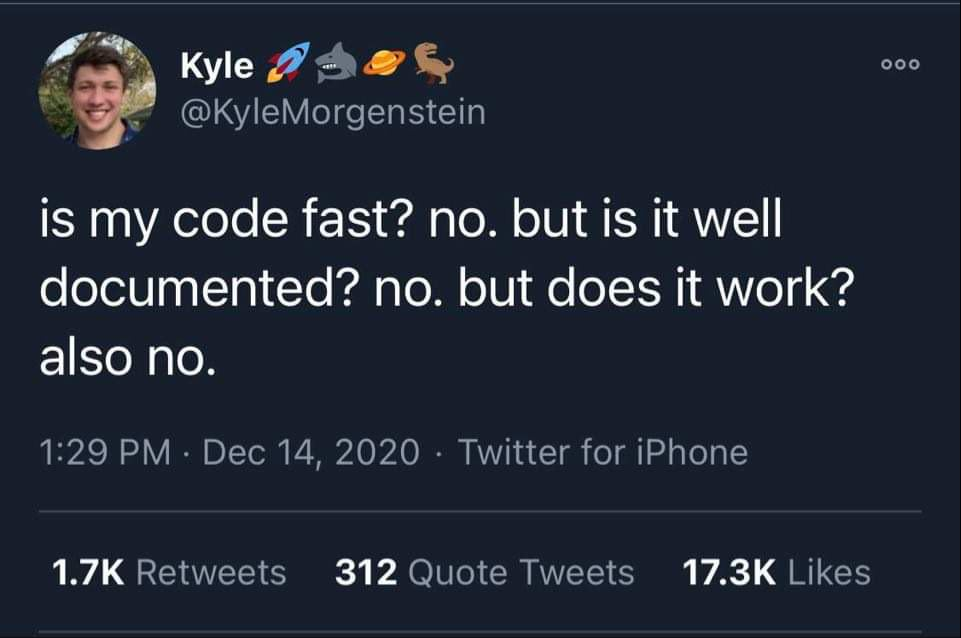